In [177]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [178]:
# Set figures Properties
params={"figure.figsize":(13,8),'axes.titlesize':20,
         'xtick.labelsize':20,
         'ytick.labelsize':20,'axes.labelsize':20}
plt.rcParams.update(params)

In [298]:
# Load data
cube = np.loadtxt('FRB010125_txt', delimiter=',')

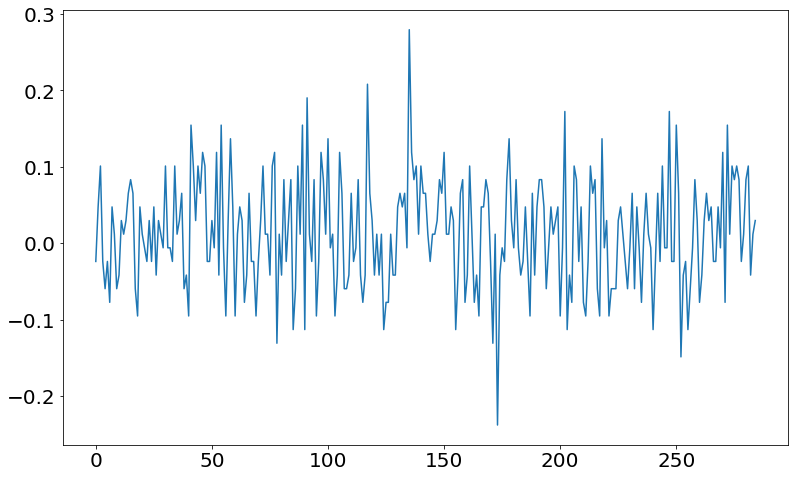

In [302]:
plt.plot(cube[24])

In [304]:
# Observing parameters 
bw = 288 # Mhz
n_chan = 96 
f_res = bw/n_chan # Mhz
f_center = 1374 # Mhz
t_res = 7 # ms

In [305]:
# Calculate frequency range
def freq_value(n_chan, f_cent, f_res):
    
        hfreq = f_cent + bw/2
        freqs = []
        
        for i in range(n_chan):
            freqs.append(hfreq - (i*f_res)) 
        
        return np.array(freqs)

In [306]:
freqs = freq_value(n_chan, f_center, f_res)

In [307]:
# We will fit a gaussian on those 5 data
chans = [24,60,68,79]
Mydict = {}
for i in range(len(chans)):
    Mydict[i] = cube[chans[i]]

In [308]:
# Normalize data
for i in range(len(Mydict)):
    Mydict[i] = (Mydict[i] - Mydict[i].mean())/Mydict[i].std()

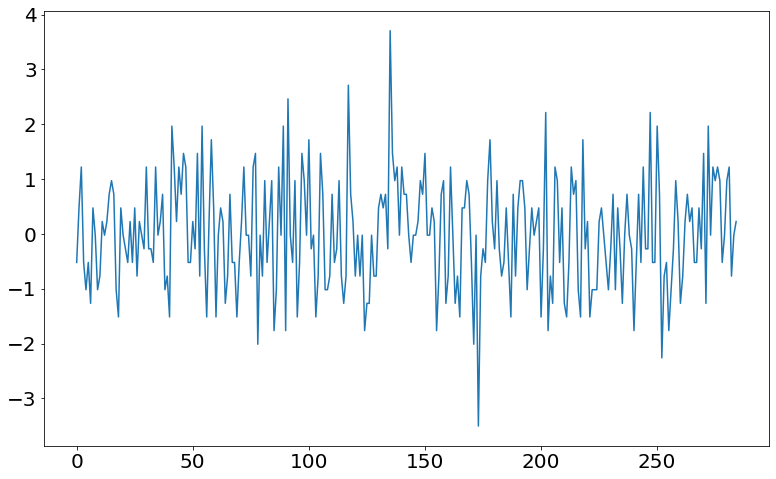

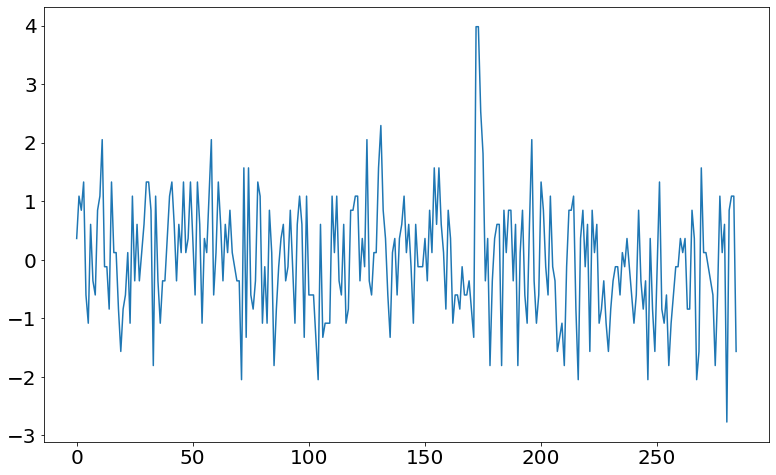

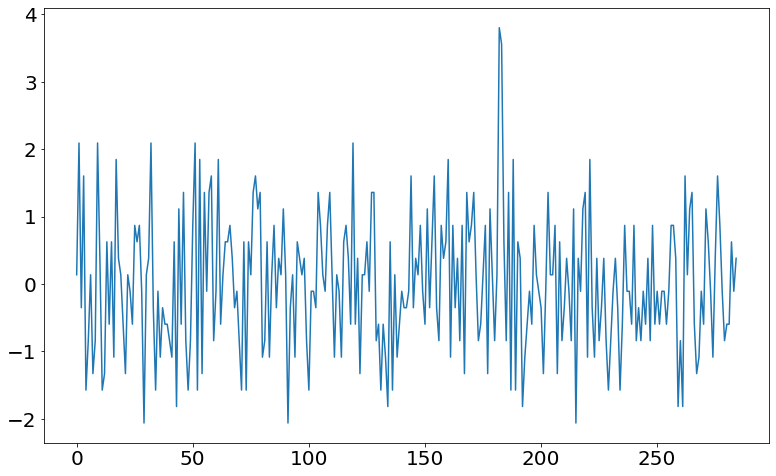

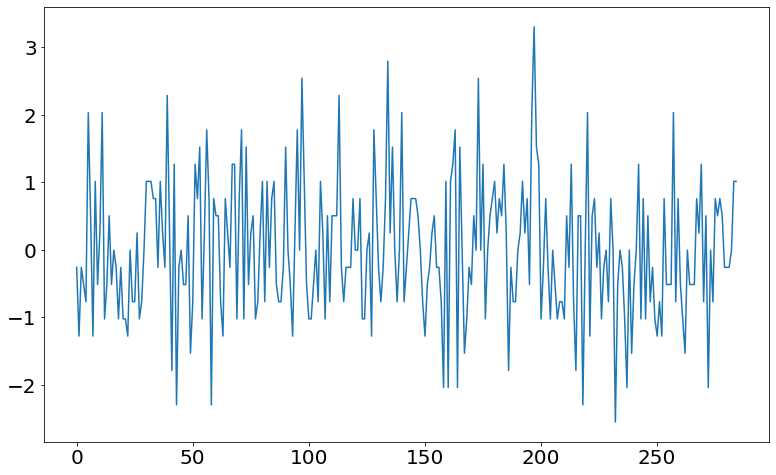

In [309]:
# Visulalize the normalize data
for i in range(len(Mydict)):
    plt.figure()
    plt.plot(Mydict[i])

In [352]:
# Fit with a gaussian curve
from scipy.optimize import curve_fit
def gaussian(x,amp,mu,sigma):
    return amp*np.exp(-(x - mu)**2/(2*sigma**2))

In [311]:
xi = np.arange(len(Mydict[0]))

In [318]:
# Initial guess
guess = [[4,130,3],[4,175,3], [4,180,3],[5,200,5]]

In [368]:
params = []
arr = []
for i in range(len(Mydict)):
    prms, pcov = curve_fit(gaussian, xi, Mydict[i], p0=[guess[i]])# p0 = [3, 19, 5])
    params.append(prms)
    arr.append(prms[1])

In [369]:
params

[array([  1.73299543, 135.8583615 ,   2.40892082]),
 array([  4.45572967, 173.01191275,  -1.02173217]),
 array([  4.94578304, 182.48863897,  -0.65070237]),
 array([  3.27251882, 197.01172903,   0.92376212])]

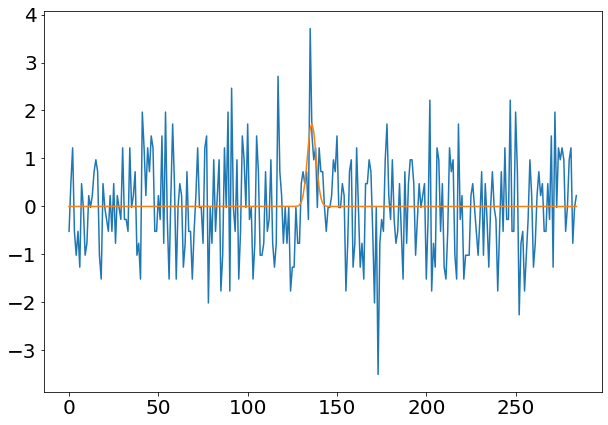

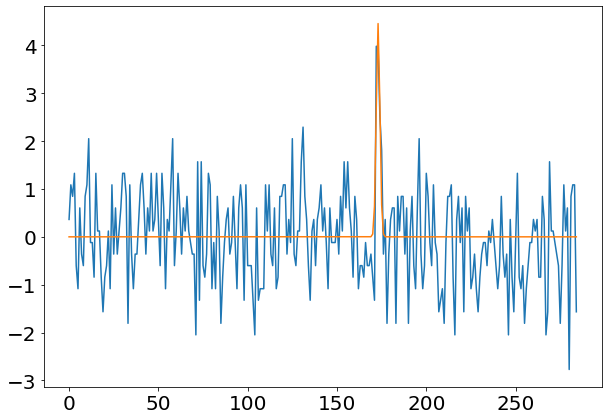

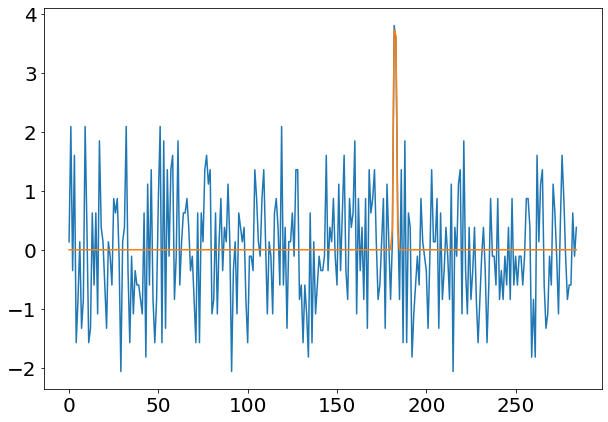

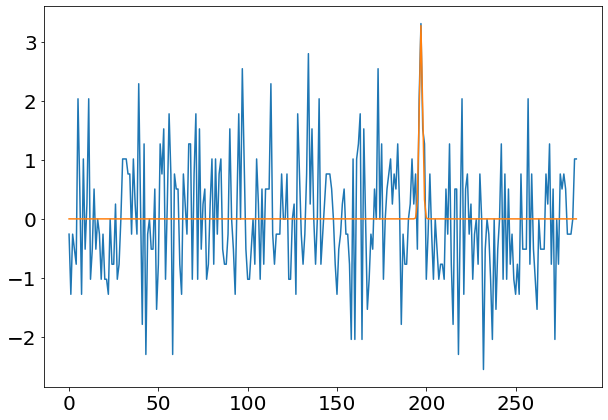

In [370]:
for i in range(len(Mydict)):
    plt.figure(figsize=[10,7])
    #plt.title('single pulse', fontsize = 20)
    #plt.xlabel('Time (ms)', fontsize = 20)
    #plt.ylabel('Power (arbitrary unit)', fontsize = 20)
    plt.plot(Mydict[i])
    prms = params[i]
    ypred = gaussian(xi, prms[0], prms[1], prms[2])
    plt.plot(ypred)

In [371]:
# Freq for the fitted channels above
fr_fitted = freqs[chans]

In [372]:
# Convert arrival to ms 
arr = np.array(arr)*7

In [373]:
arr

array([ 951.00853051, 1211.08338926, 1277.42047282, 1379.0821032 ])

In [374]:
def slope(f2, f1):

    # convert to Ghz
    lo = f1*1e-3  
    hi = f2*1e-3
        
    return 4.15*(lo**(-2) - hi**(-2))

In [375]:
index = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]

In [376]:
# Calculate the different arrival time
listarr = []
for i in range(len(index)):
    listarr.append(np.absolute(arr[index[i][0]] - arr[index[i][1]]))

In [377]:
# Calculate the different slope 
listslope = []
for i in range(len(index)):
    
    listslope.append(slope(fr_fitted[index[i][0]], fr_fitted[index[i][1]]))

In [378]:
def line(x, dm):
    return x*dm

In [379]:
prm, popt = curve_fit(line, listslope, listarr)

In [380]:
prm

array([784.6987785])

In [381]:
popt

array([[7.84825605]])

In [331]:
class dedisp():
    
    def __init__(self, bw, freqs, nchan = 96, t_res = 4):
        
        self.bw = bw
        self.freqs = freqs
        self.f_ref = freqs[0]
        self.nchan = nchan
        self.f_res = self.bw/self.nchan
        self.t_res = t_res
    
    # Calculate time delay in the image
    def time_delay(self, DM, f):
        
        # convert to Ghz
        lo = f*1e-3  
        hi = self.f_ref*1e-3
        
        # calculate delay
        dt = 4.15*(lo**(-2) - hi**(-2))*DM
        
        return np.int(np.round(dt/self.t_res)) 
    
    # Dedisperse 
    # The input frame should be [freq, time]
    # Here we approximate the dedispersed pulse with np.roll
    def dedisperse(self, frame, DM):
        
        # Calculate all the delay btw each freq channel
        delays = []
        for i in range(len(self.freqs)):
            delays.append(self.time_delay(DM, self.freqs[i]))
        
        frame2 = []
        
        for i in range(len(frame)):
            frame2.append(np.roll(frame[i], -delays[i]))
                
        return np.array(frame2)
    
    # Time series data
    def timeseries(self, frame):
        return np.sum(frame, axis = 0)
    
    # Mean absolute deviation
    def mad(self, x):
        mu = np.mean(x)
        return np.mean(np.absolute(x - mu))
    
    # Evaluate mad for different dm values
    def evall(self, frame):
        
        mad = []
        # Lets try DM from 0 to 100 spaced by 0.5
        DMs = np.arange(300,1000,1)
        
        for i in DMs:
            ddisp = self.dedisperse(frame, i)
            ddisp = self.timeseries(ddisp)
            mad.append(self.mad(ddisp))
        
        return DMs, np.array(mad)

In [382]:
process = dedisp(bw, freqs, t_res= t_res)

In [388]:
dedpulse = process.dedisperse(cube, prm[0])

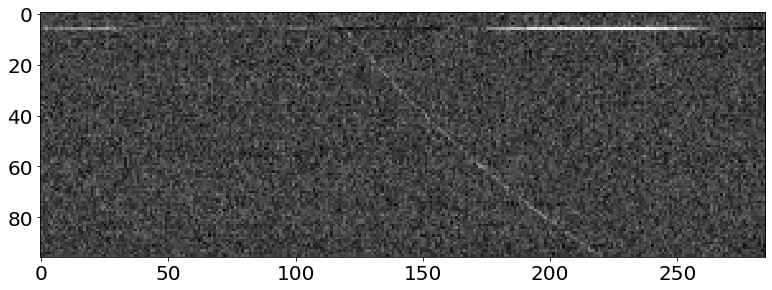

In [395]:
plt.imshow(cube, cmap='gray')

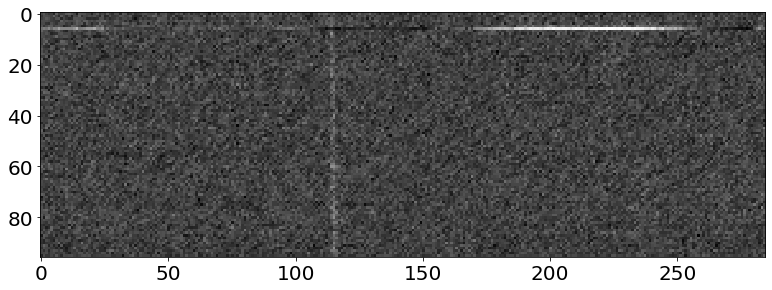

In [393]:
plt.imshow(dedpulse, cmap='gray')

In [396]:
tserie = process.timeseries(dedpulse)

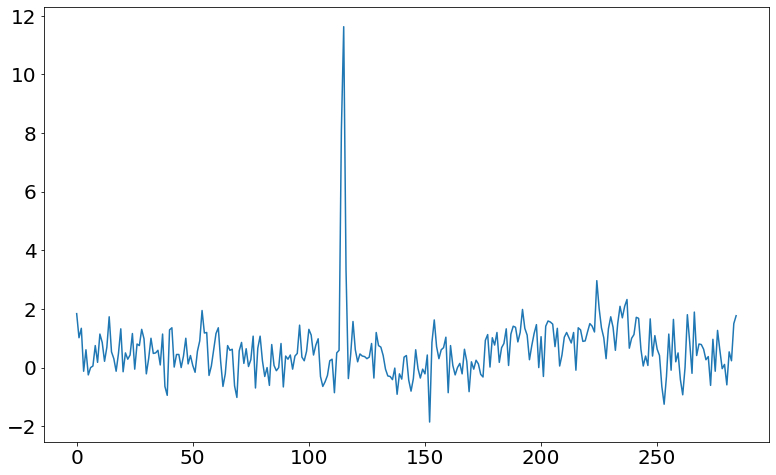

In [397]:
plt.plot(tserie)

In [401]:
cube_4 = np.loadtxt('FRB010125_4ms_txt', delimiter=',')

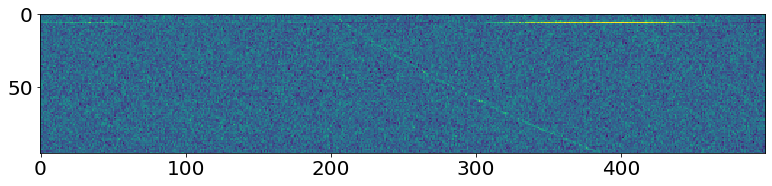

In [402]:
plt.imshow(cube_4)

In [403]:
process2 = dedisp(bw, freqs, t_res= 4)

In [406]:
dedisp2 = process2.dedisperse(cube_4, prm[0])

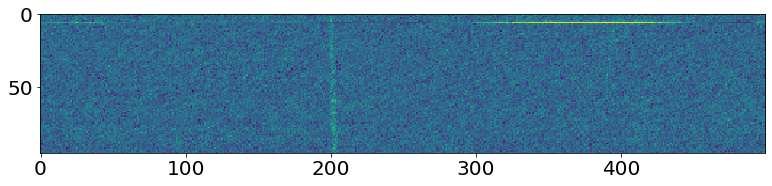

In [407]:
plt.imshow(dedisp2)

In [408]:
tseries2 = process2.timeseries(dedisp2)

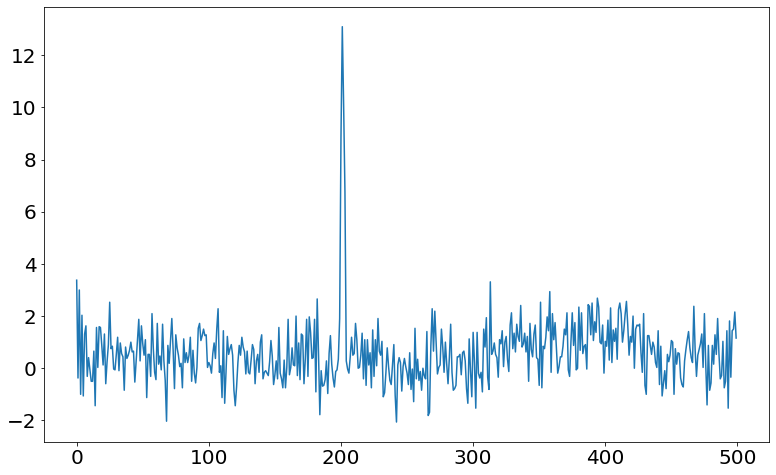

In [409]:
plt.plot(tseries2)

In [410]:
# Fit a gaussian to determine the width
xx = np.arange(len(tseries2))
pulse2, unc2 = curve_fit(gaussian, xx, tseries2, p0=[12.5,202,9])

In [411]:
pulse2

array([ 13.16164377, 201.25279882,   1.28762471])

In [414]:
# Width at 2 sigma 
w = pulse2[2]*2*4

In [419]:
print('pulse width = %.f'%(w))

pulse width = 10


In [417]:
ypred = gaussian(xx, pulse2[0], pulse2[1], pulse2[2])

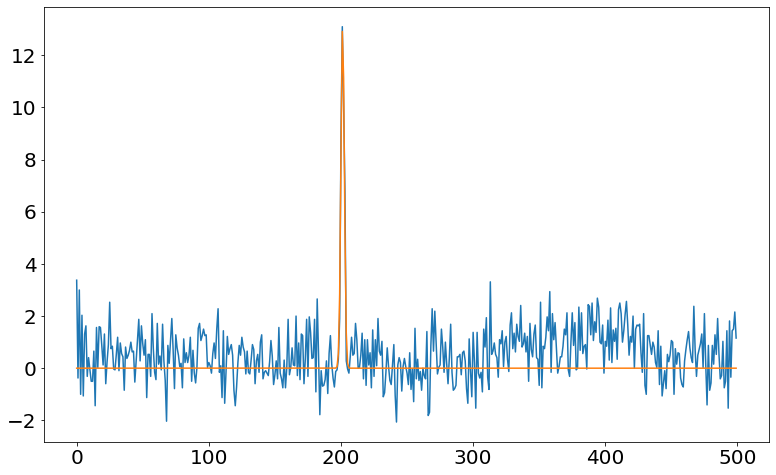

In [418]:
plt.plot(tseries2)
plt.plot(ypred)